In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import torchmetrics
from torchmetrics import MeanSquaredError

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
from typing import Tuple, Set, List, Union

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path

sess_start           = params.sess_start
sess_end             = params.sess_end

look_back            = params.look_back_tick
sess_start_pred      = params.sess_start_pred_tick
sess_start_shift     = params.sess_start_shift_tick

n_trials = 100
n_jobs = 1

In [4]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,bb_width_20,stoch_k_14,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-0.929333,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763664,0.764807,0.016650
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-0.921566,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763647,0.764790,0.018001
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-0.913246,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763631,0.764773,0.019462
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-0.904541,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763614,0.764757,0.021042
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-0.895592,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763597,0.764740,0.022750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.475806,0.704918,0.500000,0.705997,5.467381,2.024482,0.367023,-0.130453,2.191746,1.957857,...,0.122381,0.619888,0.342752,1,-0.939,0.039,0.146,196.667400,196.962600,0.000000
2025-06-18 20:57:00,0.685484,0.836066,0.387097,0.478780,6.628840,2.207440,0.460866,-0.093452,2.466615,1.999189,...,0.187641,0.223810,0.415204,1,-0.939,0.039,0.146,196.527500,196.822500,0.000000
2025-06-18 20:58:00,0.467742,0.508197,0.500000,0.470665,7.630343,2.216153,0.497086,-0.060109,2.478653,2.004989,...,0.241322,0.209943,0.370103,1,-0.939,0.039,0.146,196.522500,196.817500,0.000000
2025-06-18 20:59:00,0.475806,0.524590,-0.129032,-0.227217,31.658646,2.487280,0.408182,-0.062549,2.057321,1.614144,...,0.245429,-0.982637,-0.192907,1,-0.939,0.039,0.146,196.092800,196.387200,0.000000


{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 8,
 'CLIPNORM': 1.0,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'EARLY_STOP_PATIENCE': 15,
 'ETA_MIN': 5e-06,
 'INITIAL_LR': 0.0005,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 5,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 128,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 1e-05}


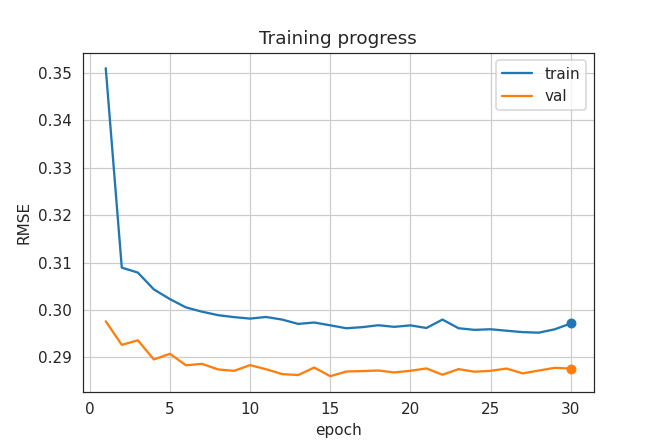

DualMemoryLSTM(
  (short_lstm): LSTM(15, 128, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.1, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 128, batch_first=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [5]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [6]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = look_back,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    sess_start    = False # predictions from sess_start_pred
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_feat,
    look_back    = look_back,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH'],
    sess_start   = False # predictions from sess_start_pred
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_feat,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1694522, val=353129, te=364691
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..782], total days=783
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3808
   ds_val days: 783
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [7]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.45447
Test zero‐forecast baseline RMSE = 0.43857


In [8]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

std val: 0.35366103
std test: 0.34320843


In [9]:
# def evaluate_model(
#     model: torch.nn.Module,
#     loader: torch.utils.data.DataLoader,
#     device: torch.device,
#     split_name: str
# ) -> Tuple[float, np.ndarray]:
#     """
#     Fast per-day RMSE + preds, exactly matching  val‐phase logic:

#     • Expects each batch from `loader` to be a tuple of at least
#       (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
#     • xb_batch: Tensor(B, W, look_back, F)
#     • yb_batch: Tensor(B, W)
#     • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
#     """

#     model.to(device).eval()
#     model.h_short = model.h_long = None

#     prev_day_id   = None
#     total_sq_err  = 0.0
#     total_windows = 0
#     all_preds     = []

#     with torch.no_grad():
#         for batch in tqdm(loader, desc=split_name, unit="batch"):
#             # grab only the first three outputs, ignore raw_close/raw_bid/etc.
#             xb_batch, yb_batch, day_id_batch = batch[:3]

#             # move to device once
#             xb_batch     = xb_batch.to(device, non_blocking=True)
#             yb_batch     = yb_batch.to(device, non_blocking=True)
#             day_id_batch = day_id_batch.to(device, non_blocking=True)

#             # if we got one day_id per window, reduce to one/day
#             if day_id_batch.dim() > 1:
#                 day_id_batch = day_id_batch[:, 0]

#             B, W = xb_batch.shape[0], xb_batch.shape[1]

#             for i in range(B):
#                 x_day  = xb_batch[i]             # (W, look_back, F)
#                 y_day  = yb_batch[i].view(-1)    # (W,)
#                 day_id = int(day_id_batch[i].item())

#                 # reset LSTM states exactly as in val loop
#                 model.reset_short()
#                 if prev_day_id is not None and day_id < prev_day_id:
#                     model.reset_long()
#                 prev_day_id = day_id

#                 out      = model(x_day)          # (W, look_back, 1)
#                 pred_day = out[:, -1, 0]         # (W,)

#                 total_sq_err  += (pred_day - y_day).pow(2).sum().item()
#                 total_windows += y_day.numel()
#                 all_preds.append(pred_day.cpu().numpy())

#     rmse  = math.sqrt(total_sq_err / total_windows)
#     preds = np.concatenate(all_preds, axis=0)

#     print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
#     return rmse, preds


In [10]:
# -----------------------------------------------------------------------------
# 1) Your existing evaluate_model (unchanged, already working)
# -----------------------------------------------------------------------------
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching val‐phase logic.

    Returns
    -------
    rmse: float
        Root‐mean‐squared error over all sliding windows.
    preds: np.ndarray of shape (N_windows,)
        Stacked predictions in the exact order the loader emits them.
    """
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            xb, yb, day_ids = batch[:3]
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            day_ids = day_ids.to(device, non_blocking=True)

            # if day_ids is (B, W), reduce to one id per window
            if day_ids.dim() > 1:
                day_ids = day_ids[:, 0]

            B, W = xb.shape[0], xb.shape[1]
            for i in range(B):
                x_day  = xb[i]                   # (W, look_back, F)
                y_day  = yb[i].view(-1)         # (W,)
                day_id = int(day_ids[i].item())

                # exactly as in your validation loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)
    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds

In [11]:
train_rmse, train_preds = evaluate_model(
    model_best, train_loader, device,
    split_name="Train"
)
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

print("\nTrain preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Train:   0%|          | 0/119 [00:00<?, ?batch/s]


Train RMSE over 1708320 windows = 0.29699


Validation:   0%|          | 0/783 [00:00<?, ?batch/s]


Validation RMSE over 353129 windows = 0.28768


Test:   0%|          | 0/809 [00:00<?, ?batch/s]


Test RMSE over 364691 windows = 0.29494

Train preds: 1708320
Val   preds: 353129
Test  preds: 364691


In [ ]:
# def add_pred_and_split(
#     df: pd.DataFrame,
#     train_preds: np.ndarray,
#     val_preds: np.ndarray,
#     test_preds: np.ndarray,
#     day_id_tr: np.ndarray,
#     day_id_val: np.ndarray,
#     day_id_te: np.ndarray
# ) -> Tuple[pd.DataFrame, Set[pd.Timestamp], pd.DataFrame, List[pd.Timestamp]]:
#     """
#     Attach model predictions to each bar at the end of sliding windows, then split.

#     Predictions are only applied to the last bar of each look_back-length window,
#     starting at sess_start_pred each trading day.

#     Returns
#     -------
#     df_train_val
#         Subset of df for train+val days, with two new columns:
#         - pred_signal: stamped predictions at window-end bars
#         - pred_action: int placeholder for your downstream logic
#     train_val_days
#         Set of calendar dates used for training + validation.
#     df_test
#         Same as df_train_val but only for test days.
#     te_days
#         Sorted list of test-day dates.
#     """
#     # 1) Prepare output DataFrame
#     df_pred = df.copy()
#     df_pred["pred_signal"] = np.nan
#     df_pred["pred_action"] = 0

#     # 2) Map day-id arrays to actual calendar dates
#     all_days = sorted(df_pred.index.normalize().unique())
#     tr_days  = [all_days[i] for i in np.unique(day_id_tr).astype(int)]
#     val_days = [all_days[i] for i in np.unique(day_id_val).astype(int)]
#     te_days  = [all_days[i] for i in np.unique(day_id_te).astype(int)]

#     def stamp_split(days: List[pd.Timestamp], preds: np.ndarray, name: str):
#         """
#         Stamp preds onto df_pred at each window’s end bar for the given days.
#         """
#         # Collect all window-end timestamps
#         end_timestamps = []
#         for day in tqdm(days, desc=f"Stamping {name}", leave=False):
#             # All bars on that day at or after session start
#             mask = (
#                 (df_pred.index.normalize() == day)
#                 & (df_pred.index.time >= sess_start_pred)
#             )
#             bars = df_pred.index[mask]
#             # Drop the first (look_back-1) bars—they can’t end a full window
#             end_timestamps.append(bars[look_back - 1 :])

#         # Flatten into one DatetimeIndex
#         end_idx = pd.DatetimeIndex(np.concatenate(end_timestamps))

#         # Sanity check: one pred per window-end
#         if len(end_idx) != len(preds):
#             raise ValueError(
#                 f"{name}: expected {len(end_idx)} slots, got {len(preds)} preds"
#             )

#         # Write predictions
#         df_pred.loc[end_idx, "pred_signal"] = preds

#     # 3) Stamp each split
#     stamp_split(tr_days, train_preds, name="Train")
#     stamp_split(val_days, val_preds,   name="Val")
#     stamp_split(te_days,  test_preds,  name="Test")

#     # 4) Split DataFrames back out
#     train_val_days = set(tr_days + val_days)
#     df_train_val   = df_pred[df_pred.index.normalize().isin(train_val_days)].copy()
#     df_test        = df_pred[df_pred.index.normalize().isin(te_days)].copy()

#     return df_train_val, train_val_days, df_test, te_days


In [47]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds: np.ndarray,
    test_preds: np.ndarray,
    day_id_tr: np.ndarray,
    day_id_val: np.ndarray,
    day_id_te: np.ndarray
) -> Tuple[pd.DataFrame, Set[pd.Timestamp], pd.DataFrame, List[pd.Timestamp]]:

    print("⚡️ Starting add_pred_and_split")
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    df2["pred_action"] = 0

    # 1) Map day-ids → calendar dates
    days = df2.index.normalize()
    uniq = sorted(days.unique())
    tr_days = [uniq[i] for i in np.unique(day_id_tr).astype(int)]
    vl_days = [uniq[i] for i in np.unique(day_id_val).astype(int)]
    te_days = [uniq[i] for i in np.unique(day_id_te).astype(int)]
    print(f" • Found {len(uniq)} total days → "
          f"{len(tr_days)} train, {len(vl_days)} val, {len(te_days)} test days")

    # 2) Compute per-day position
    df2["day"] = days
    df2["cnt"] = df2.groupby("day").cumcount()

    # 3) Build window-end mask
    end_mask = (
        (df2.index.time >= sess_start_pred)
        & (df2["cnt"] >= look_back - 1)
    )
    print(f" • Window-end mask hits {end_mask.sum()} bars out of {len(df2)} total")

    # 4) Grab the exact end-bar indices for each split
    idx_tr  = df2.index[end_mask & df2["day"].isin(tr_days)]
    idx_val = df2.index[end_mask & df2["day"].isin(vl_days)]
    idx_te  = df2.index[end_mask & df2["day"].isin(te_days)]
    print(f" • Train windows: {len(idx_tr)},  Val windows: {len(idx_val)},  Test windows: {len(idx_te)}")

    # 5) Stamp preds (silently truncates if preds array is longer)
    n_tr_use  = min(len(idx_tr),  len(train_preds))
    n_val_use = min(len(idx_val), len(val_preds))
    n_te_use  = min(len(idx_te),  len(test_preds))
    print(f" • Using {n_tr_use}/{len(train_preds)} train preds, "
          f"{n_val_use}/{len(val_preds)} val preds, "
          f"{n_te_use}/{len(test_preds)} test preds")

    df2.loc[idx_tr[:n_tr_use],  "pred_signal"] = train_preds[:n_tr_use]
    df2.loc[idx_val[:n_val_use], "pred_signal"] = val_preds[:n_val_use]
    df2.loc[idx_te[:n_te_use],  "pred_signal"] = test_preds[:n_te_use]

    # 6) Split back into train+val vs test
    tv_set   = set(tr_days + vl_days)
    df_trval = df2[df2["day"].isin(tv_set)].copy().drop(columns=["day","cnt"])
    df_test  = df2[df2["day"].isin(te_days)].copy().drop(columns=["day","cnt"])
    print(f" • Output shapes → df_train_val: {df_trval.shape}, df_test: {df_test.shape}")
    print("✅ Finished add_pred_and_split\n")

    return df_trval, tv_set, df_test, te_days


In [48]:
df_train_val, train_val_days, df_test, te_days = add_pred_and_split(
    df=df_feat,
    train_preds=train_preds,
    val_preds=val_preds,
    test_preds=test_preds,
    day_id_tr=day_id_tr,
    day_id_val=day_id_val,
    day_id_te=day_id_te
)

df_train_val

⚡️ Starting add_pred_and_split
 • Found 5400 total days → 3808 train, 783 val, 809 test days
 • Window-end mask hits 2412892 bars out of 3601230 total
 • Train windows: 1695072,  Val windows: 353129,  Test windows: 364691
 • Using 1695072/1708320 train preds, 353129/353129 val preds, 364691/364691 test preds
 • Output shapes → df_train_val: (3033528, 31), df_test: (567702, 31)
✅ Finished add_pred_and_split



,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal,pred_signal,pred_action
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-1.561625,0,0.493,-0.976,0.351,0.763664,0.764807,0.016650,NaN,0
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-1.561625,0,0.493,-0.976,0.351,0.763647,0.764790,0.018001,NaN,0
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-1.561625,0,0.493,-0.976,0.351,0.763631,0.764773,0.019462,NaN,0
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-1.561625,0,0.493,-0.976,0.351,0.763614,0.764757,0.021042,NaN,0
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-1.561625,0,0.493,-0.976,0.351,0.763597,0.764740,0.022750,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,0.736230,0.747917,0.784043,0.790310,2.263197,0.652514,0.741828,0.738415,0.274413,0.321477,...,1.211724,1,-0.939,0.973,0.979,175.238500,175.501500,0.566043,0.186670,0
2022-03-28 20:57:00,0.786714,0.797917,0.841489,0.822932,3.136585,0.765180,0.784641,0.743795,0.743839,0.520116,...,1.289475,1,-0.939,0.973,0.979,175.316000,175.579200,0.395597,0.223000,0
2022-03-28 20:58:00,0.824577,0.839583,0.881915,0.880694,3.910116,0.836338,0.825969,0.753591,1.139913,0.770887,...,1.438055,1,-0.939,0.973,0.979,175.453300,175.716700,0.014998,0.237760,0
2022-03-28 20:59:00,0.881372,0.897917,0.911702,0.882796,9.226442,0.943074,0.855498,0.762535,1.398787,0.960884,...,1.284055,1,-0.939,0.973,0.979,175.458300,175.721700,0.000000,0.262166,0


In [41]:

def objective(trial):
    # —————— 1) Clean slate for this trial ——————
    df_master["pred_action"].values[:] = 0

    # —————— 2) Hyper-parameter suggestions ——————
    pred_threshold     = trial.suggest_float("pred_threshold",     0.15, 0.95)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.3)

    # —————— 3) Generate actions per day ——————
    print('-----------------------------------')
    print("Generate actions per day...")
    for day, idxs in day_positions.items():
        day_df = day_dfs[day]
        day_act = trades.generate_trade_actions(
            df=day_df,
            col_signal="pred_signal",
            col_action="pred_action",
            buy_threshold=pred_threshold,
            trailing_stop_pcs=trailing_stop_pred,
            sess_start=params.sess_start
        )["pred_action"].fillna(0).astype(np.int8).values
        df_master["pred_action"].values[idxs] = day_act

    # —————— 4) Simulate & score ——————
    print("Simulate and compute average daily P&L...")
    sim_results = trades.simulate_trading(
        results_by_day_sign=df_master,
        col_action="pred_action",
        sess_start=params.sess_start,
        sess_end=params.sess_end,
        ticker=params.ticker
    )

    # — include all actual trading days in the average —
    all_stats  = [stats for _, (_, _, stats) in sim_results.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in sim_results.items():
        del df_sim, trades_list
    del sim_results
    gc.collect()
    
    num_trade_days  = len(sim_results)

    daily_returns = [s["Strategy Return ($)"] for s in all_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_trade_days if num_trade_days else 0.0

    total_trades  = sum(len(s["Trades Returns ($)"]) for s in all_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    print(f"→ Total return across {num_trade_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)             : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                            : {total_trades}")
    print(f"→ Avg return per trade                    : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [42]:
# rest of your Optuna setup & study.optimize() 
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)
storage = RDBStorage(
    url="sqlite:///optuna_study.db",
    engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
)
study = optuna.create_study(
    storage        = storage,
    load_if_exists = True,
    direction      = "maximize",
    pruner         = pruner,
)
study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial    = True,
    show_progress_bar = False,
    catch             = (MemoryError,),
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

[I 2025-08-21 21:51:53,131] A new study created in RDB with name: no-name-c6707a3f-362b-4077-9440-7fd03fb5b18e
[W 2025-08-21 21:51:53,162] Trial 0 failed with parameters: {} because of the following error: NameError("name 'df_master' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1338/2284338488.py", line 3, in objective
    df_master["pred_action"].values[:] = 0
    ^^^^^^^^^
NameError: name 'df_master' is not defined
[W 2025-08-21 21:51:53,168] Trial 0 failed with value None.


NameError: name 'df_master' is not defined

In [ ]:
# Final plots & JSON dump (unchanged)...
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_train_val.index.normalize().min().strftime("%Y%m%d")
last_day  = df_train_val.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

print(stats)

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='true signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal')
plt.axis('equal')
plt.show()

In [ ]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_train_val,              # DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    sess_start          = params.sess_start,   
    sess_end            = params.sess_end,         
    ticker              = params.ticker
)


In [ ]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)
